UAS BIG DATA

FARIS AMMAR FAISHAL
22.11.5081

ATQIYA TRIANDA PUTRA A.
22.11.5083

In [1]:
!pip install pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, mean, corr
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql.types import IntegerType, DoubleType
import pandas as pd


In [3]:
spark = SparkSession.builder \
    .appName("Student Performance Analysis") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Big Data Lanjut/StudentPerformanceFactors.csv'
data = spark.read.csv(file_path, header=True, inferSchema=True)


Mounted at /content/drive


LANGKAH C

In [6]:
data.printSchema()

root
 |-- Hours_Studied: integer (nullable = true)
 |-- Attendance: integer (nullable = true)
 |-- Parental_Involvement: string (nullable = true)
 |-- Access_to_Resources: string (nullable = true)
 |-- Extracurricular_Activities: string (nullable = true)
 |-- Sleep_Hours: integer (nullable = true)
 |-- Previous_Scores: integer (nullable = true)
 |-- Motivation_Level: string (nullable = true)
 |-- Internet_Access: string (nullable = true)
 |-- Tutoring_Sessions: integer (nullable = true)
 |-- Family_Income: string (nullable = true)
 |-- Teacher_Quality: string (nullable = true)
 |-- School_Type: string (nullable = true)
 |-- Peer_Influence: string (nullable = true)
 |-- Physical_Activity: integer (nullable = true)
 |-- Learning_Disabilities: string (nullable = true)
 |-- Parental_Education_Level: string (nullable = true)
 |-- Distance_from_Home: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Exam_Score: integer (nullable = true)



In [7]:
data.show(5)

+-------------+----------+--------------------+-------------------+--------------------------+-----------+---------------+----------------+---------------+-----------------+-------------+---------------+-----------+--------------+-----------------+---------------------+------------------------+------------------+------+----------+
|Hours_Studied|Attendance|Parental_Involvement|Access_to_Resources|Extracurricular_Activities|Sleep_Hours|Previous_Scores|Motivation_Level|Internet_Access|Tutoring_Sessions|Family_Income|Teacher_Quality|School_Type|Peer_Influence|Physical_Activity|Learning_Disabilities|Parental_Education_Level|Distance_from_Home|Gender|Exam_Score|
+-------------+----------+--------------------+-------------------+--------------------------+-----------+---------------+----------------+---------------+-----------------+-------------+---------------+-----------+--------------+-----------------+---------------------+------------------------+------------------+------+----------+
|

In [8]:
print("\nNull Value Counts:")
null_counts = data.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in data.columns])
null_counts.show()



Null Value Counts:
+-------------+----------+--------------------+-------------------+--------------------------+-----------+---------------+----------------+---------------+-----------------+-------------+---------------+-----------+--------------+-----------------+---------------------+------------------------+------------------+------+----------+
|Hours_Studied|Attendance|Parental_Involvement|Access_to_Resources|Extracurricular_Activities|Sleep_Hours|Previous_Scores|Motivation_Level|Internet_Access|Tutoring_Sessions|Family_Income|Teacher_Quality|School_Type|Peer_Influence|Physical_Activity|Learning_Disabilities|Parental_Education_Level|Distance_from_Home|Gender|Exam_Score|
+-------------+----------+--------------------+-------------------+--------------------------+-----------+---------------+----------------+---------------+-----------------+-------------+---------------+-----------+--------------+-----------------+---------------------+------------------------+------------------+

In [9]:
# Define column mappings (old_name -> new_name)
column_mappings = {
    "Hours_Studied": "study_hours",
    "Attendance": "attendance",
    "Parental_Involvement": "parental_guidance",
    "Access_to_Resources": "resources_access",
    "Extracurricular_Activities": "extracurricular",
    "Sleep_Hours": "sleep_hours",
    "Previous_Scores": "prev_score",
    "Motivation_Level": "motivation",
    "Internet_Access": "internet_access",
    "Tutoring_Sessions": "tutoring_sessions",
    "Family_Income": "family_income",
    "Teacher_Quality": "teacher_quality",
    "School_Type": "school",
    "Peer_Influence": "peer_influence",
    "Physical_Activity": "physical_activity",
    "Learning_Disabilities": "learning_disabilities",
    "Parental_Education_Level": "parent_last_education",
    "Distance_from_Home": "home_distance",
    "Gender": "gender",
    "Exam_Score": "current_score"
}

In [10]:
#  Identify categorical and numerical columns with new names
categorical_columns = [
    "parental_guidance", "resources_access", "extracurricular", "motivation", "internet_access",
    "family_income", "teacher_quality", "school", "peer_influence", "learning_disabilities",
    "parent_last_education", "home_distance", "gender"
]

numeric_columns = [
    "study_hours", "attendance", "sleep_hours", "prev_score",
    "tutoring_sessions", "physical_activity", "current_score"
]

renamed_data = data
for old_col, new_col in column_mappings.items():
    renamed_data = renamed_data.withColumnRenamed(old_col, new_col)

print("Null values before imputation:")
null_counts = renamed_data.select([count(when(col(c).isNull() | isnan(c), c)).alias(c)
                                 for c in renamed_data.columns])
null_counts.show()

Null values before imputation:
+-----------+----------+-----------------+----------------+---------------+-----------+----------+----------+---------------+-----------------+-------------+---------------+------+--------------+-----------------+---------------------+---------------------+-------------+------+-------------+
|study_hours|attendance|parental_guidance|resources_access|extracurricular|sleep_hours|prev_score|motivation|internet_access|tutoring_sessions|family_income|teacher_quality|school|peer_influence|physical_activity|learning_disabilities|parent_last_education|home_distance|gender|current_score|
+-----------+----------+-----------------+----------------+---------------+-----------+----------+----------+---------------+-----------------+-------------+---------------+------+--------------+-----------------+---------------------+---------------------+-------------+------+-------------+
|          0|         0|                0|               0|              0|          0|   

In [11]:
total_rows = data.count()
print("\nPercentage of missing values:")
for column in data.columns:
    missing_count = data.filter(col(column).isNull()).count()
    if missing_count > 0:
        percentage = (missing_count / total_rows) * 100
        print(f"{column}: {missing_count} rows ({percentage:.2f}%)")



Percentage of missing values:
Teacher_Quality: 78 rows (1.18%)
Parental_Education_Level: 90 rows (1.36%)
Distance_from_Home: 67 rows (1.01%)


In [12]:
processed_data = renamed_data

for cat_col in categorical_columns:
    # Calculate mode
    mode_df = renamed_data.groupBy(cat_col).count().orderBy("count", ascending=False)
    mode_value = mode_df.first()[0]
    # Fill nulls with mode
    processed_data = processed_data.fillna(value=mode_value, subset=[cat_col])


In [13]:
# Create and apply StringIndexer for categorical columns
for column in categorical_columns:
    # Create temporary column name
    temp_col = f"{column}_temp"

    # Create and apply indexer
    indexer = StringIndexer(inputCol=column, outputCol=temp_col, handleInvalid="keep")
    processed_data = indexer.fit(processed_data).transform(processed_data)

    # Drop original and rename temp column
    processed_data = processed_data.drop(column).withColumnRenamed(temp_col, column)

In [14]:
#  Verify schema
print("\nFinal Schema:")
processed_data.printSchema()

# Show sample of processed data
print("\nSample of processed data:")
processed_data.show(5)


Final Schema:
root
 |-- study_hours: integer (nullable = true)
 |-- attendance: integer (nullable = true)
 |-- sleep_hours: integer (nullable = true)
 |-- prev_score: integer (nullable = true)
 |-- tutoring_sessions: integer (nullable = true)
 |-- physical_activity: integer (nullable = true)
 |-- current_score: integer (nullable = true)
 |-- parental_guidance: double (nullable = false)
 |-- resources_access: double (nullable = false)
 |-- extracurricular: double (nullable = false)
 |-- motivation: double (nullable = false)
 |-- internet_access: double (nullable = false)
 |-- family_income: double (nullable = false)
 |-- teacher_quality: double (nullable = false)
 |-- school: double (nullable = false)
 |-- peer_influence: double (nullable = false)
 |-- learning_disabilities: double (nullable = false)
 |-- parent_last_education: double (nullable = false)
 |-- home_distance: double (nullable = false)
 |-- gender: double (nullable = false)


Sample of processed data:
+-----------+--------


Calculating correlation matrix...


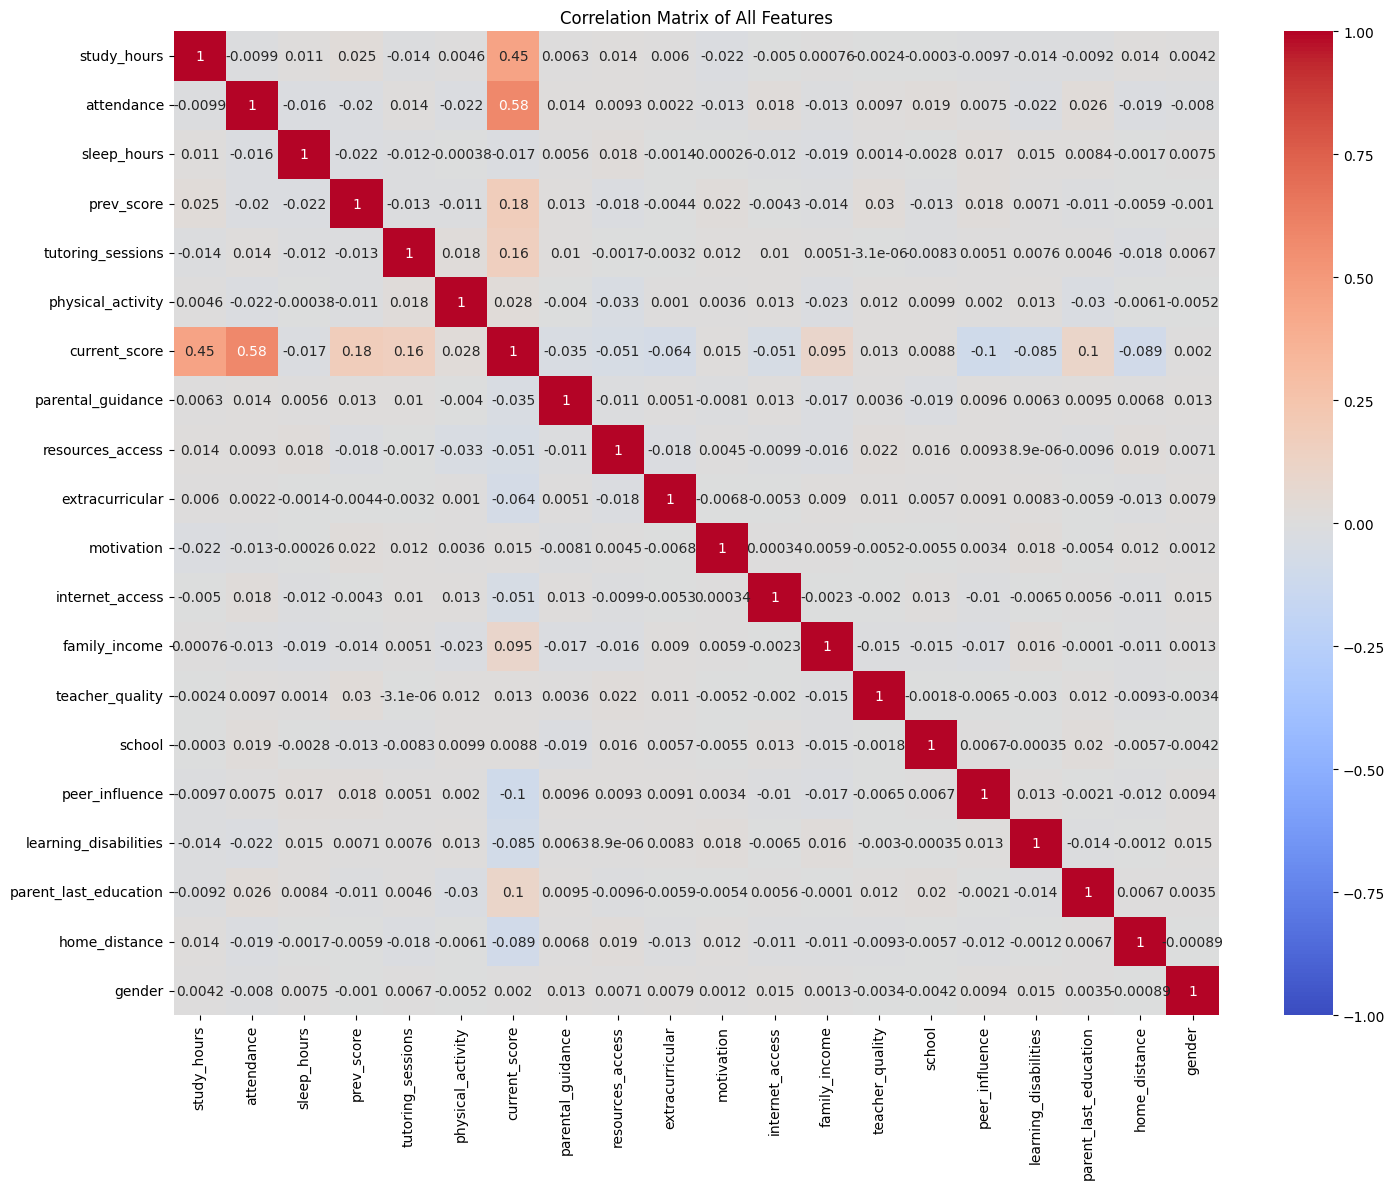

DataFrame[study_hours: int, attendance: int, sleep_hours: int, prev_score: int, tutoring_sessions: int, physical_activity: int, current_score: int, parental_guidance: double, resources_access: double, extracurricular: double, motivation: double, internet_access: double, family_income: double, teacher_quality: double, school: double, peer_influence: double, learning_disabilities: double, parent_last_education: double, home_distance: double, gender: double]

In [15]:
# Calculate correlation matrix
print("\nCalculating correlation matrix...")
numeric_data = processed_data.toPandas()
correlation_matrix = numeric_data.corr()

# Create correlation heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of All Features')
plt.tight_layout()
plt.show()

# Cache the preprocessed data
processed_data.cache()


In [16]:
print("\nPreprocessing completed successfully!")


Preprocessing completed successfully!


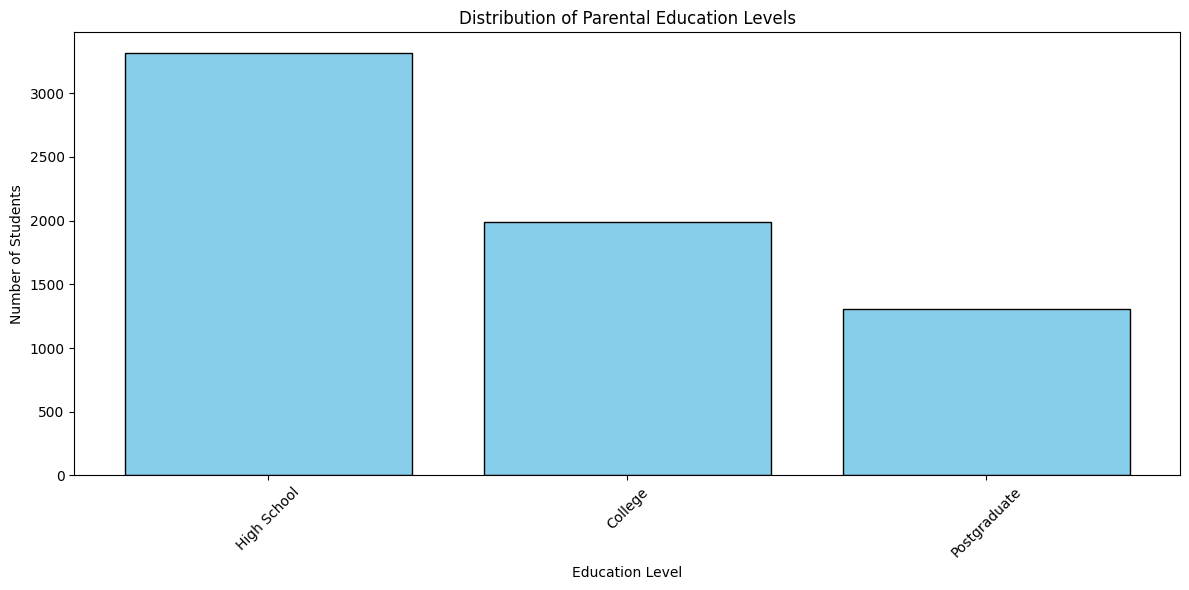

In [25]:
# Exploratory Data Analysis (EDA)

# 1. Bar Chart - Parental Education Level Distribution
parent_edu_dist = processed_data.groupBy('parent_last_education').count().orderBy('count', ascending=False).toPandas()
plt.figure(figsize=(12, 6))
plt.bar(parent_edu_dist.index, parent_edu_dist['count'], color='skyblue', edgecolor='black')
plt.title('Distribution of Parental Education Levels')
plt.xlabel('Education Level')
plt.ylabel('Number of Students')
plt.xticks(parent_edu_dist.index, ['High School', 'College', 'Postgraduate',], rotation=45)
plt.tight_layout()
plt.show()



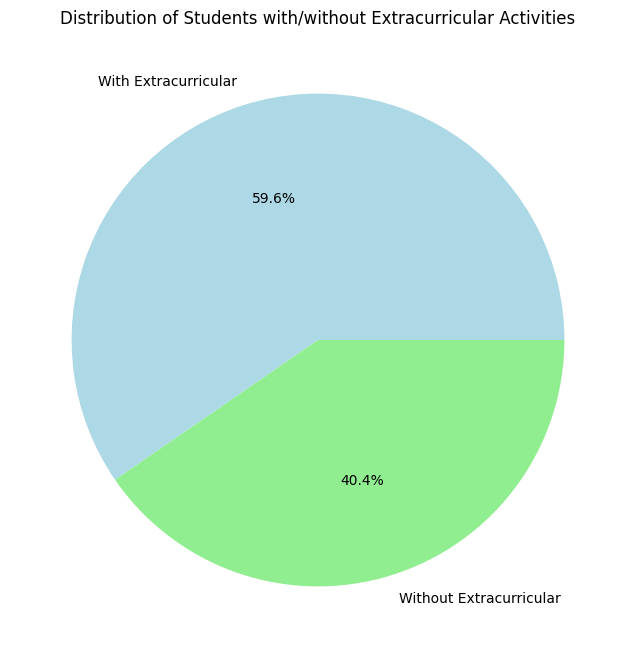

In [21]:
# 2. Pie Chart - Extracurricular Activities Distribution
extra_dist = processed_data.groupBy('extracurricular').count().toPandas()
plt.figure(figsize=(8, 8))
plt.pie(extra_dist['count'],
        labels=['With Extracurricular', 'Without Extracurricular'],
        autopct='%1.1f%%',
        colors=['lightblue', 'lightgreen'])
plt.title('Distribution of Students with/without Extracurricular Activities')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

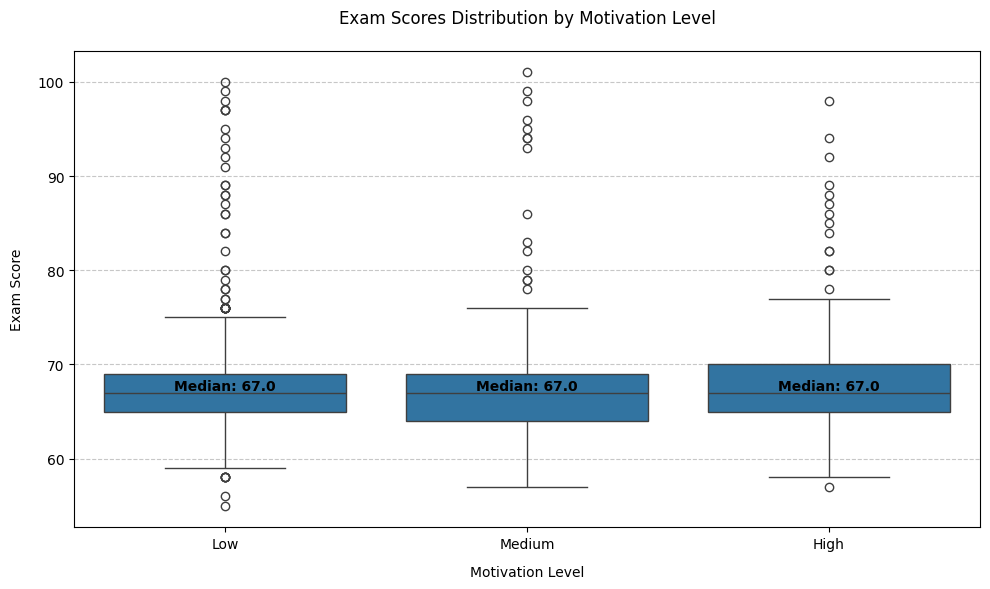

In [26]:
# 3. Box Plot - Exam Scores by Motivation Level
plt.figure(figsize=(10, 6))
df_pandas = processed_data.toPandas()
sns.boxplot(data=df_pandas, x='motivation', y='current_score')
plt.title('Exam Scores Distribution by Motivation Level', pad=20)
plt.xlabel('Motivation Level', labelpad=10)
plt.ylabel('Exam Score', labelpad=10)

# Add value labels for median lines
medians = df_pandas.groupby('motivation')['current_score'].median()
for idx, median in enumerate(medians):
    plt.text(idx, median, f'Median: {median:.1f}',
             horizontalalignment='center',
             verticalalignment='bottom',
             color='black',
             fontweight='bold')

# Customize x-axis labels
plt.xticks([0, 1, 2], ['Low', 'Medium', 'High'])

# Add a grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show


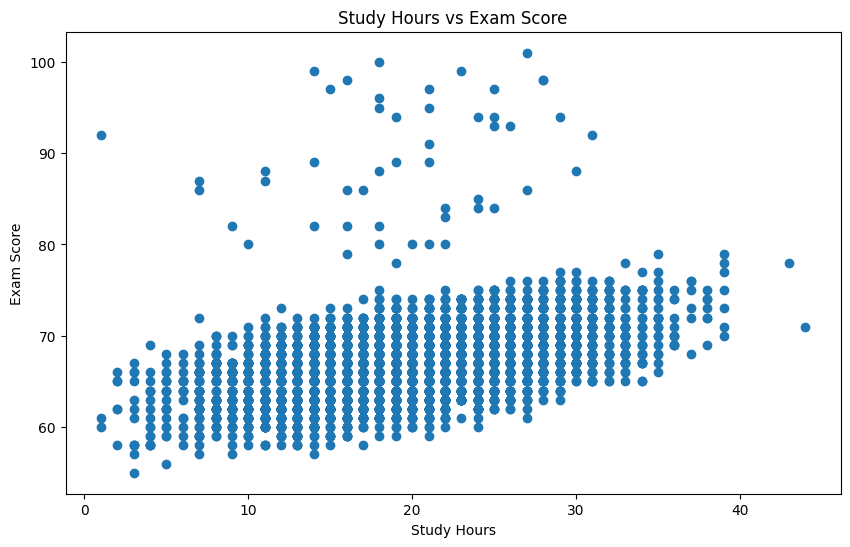

In [20]:
# 4. Scatter Plot - Study Hours vs Exam Score
plt.figure(figsize=(10, 6))
plt.scatter(processed_data.select('study_hours').toPandas(),
           processed_data.select('current_score').toPandas())
plt.title('Study Hours vs Exam Score')
plt.xlabel('Study Hours')
plt.ylabel('Exam Score')
plt.show()

In [29]:
# Feature Selection based on correlation with target variable
feature_correlations = []
target_col = 'current_score'
CORRELATION_THRESHOLD = 0.1  # Selecting features with correlation > 0.1

for column in processed_data.columns:
    if column != target_col:
        correlation = processed_data.stat.corr(column, target_col)
        feature_correlations.append((column, abs(correlation)))

# Sort features by absolute correlation
sorted_features = sorted(feature_correlations, key=lambda x: x[1], reverse=True)
print("\nFeature Correlations with Exam Score:")
for feature, correlation in sorted_features:
    print(f"{feature}: {correlation:.3f}")



Feature Correlations with Exam Score:
attendance: 0.581
study_hours: 0.445
prev_score: 0.175
tutoring_sessions: 0.157
parent_last_education: 0.104
peer_influence: 0.100
family_income: 0.095
home_distance: 0.089
learning_disabilities: 0.085
extracurricular: 0.064
internet_access: 0.051
resources_access: 0.051
parental_guidance: 0.035
physical_activity: 0.028
sleep_hours: 0.017
motivation: 0.015
teacher_quality: 0.013
school: 0.009
gender: 0.002


In [30]:
# Select top features based on correlation
selected_features = [feature[0] for feature in sorted_features if feature[1] > CORRELATION_THRESHOLD]
print(f"\nSelected Features (correlation > {CORRELATION_THRESHOLD}):", selected_features)
print(f"Number of selected features: {len(selected_features)}")


Selected Features (correlation > 0.1): ['attendance', 'study_hours', 'prev_score', 'tutoring_sessions', 'parent_last_education', 'peer_influence']
Number of selected features: 6


In [59]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col, when
import matplotlib.pyplot as plt
import numpy as np

In [60]:
# Prepare the feature vector
selected_features = ['attendance', 'study_hours', 'prev_score', 'tutoring_sessions',
                    'parent_last_education', 'peer_influence']

# Create feature vector
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
final_data = assembler.transform(processed_data)

# Create binary classification
median_score = final_data.approxQuantile("current_score", [0.5], 0.01)[0]
final_data = final_data.withColumn("label",
    when(col("current_score") >= median_score, 1.0).otherwise(0.0))

In [61]:
# Split the data
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

# Initialize the models
rf = RandomForestClassifier(labelCol="label",
                           featuresCol="features",
                           numTrees=100,
                           seed=42)

gbt = GBTClassifier(labelCol="label",
                    featuresCol="features",
                    maxIter=100,
                    seed=42)

dt = DecisionTreeClassifier(labelCol="label",
                           featuresCol="features",
                           seed=42)

layers = [len(selected_features), 20, 10, 2]
mlp = MultilayerPerceptronClassifier(labelCol="label",
                                    featuresCol="features",
                                    layers=layers,
                                    seed=42)

# Dictionary to store models
models = {
    "Random Forest": rf,
    "Gradient Boosting Tree": gbt,
    "Decision Tree": dt,
    "Neural Network": mlp
}

# Initial model evaluation
evaluator_multi = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction"
)
evaluator_binary = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction"
)

metrics_multi = ["accuracy", "weightedPrecision", "weightedRecall", "f1"]
results = {}

print("Initial Model Performance Results:")
print("-" * 50)

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train model
    fitted_model = model.fit(train_data)
    predictions = fitted_model.transform(test_data)

    # Calculate metrics
    model_metrics = {}

    # Multiclass metrics
    for metric in metrics_multi:
        evaluator_multi.setMetricName(metric)
        score = evaluator_multi.evaluate(predictions)
        model_metrics[metric] = score

    # AUC score
    auc_score = evaluator_binary.evaluate(predictions)
    model_metrics['auc'] = auc_score

    results[name] = model_metrics

    # Print results
    print(f"\n{name} Results:")
    for metric, score in model_metrics.items():
        print(f"{metric}: {score:.3f}")

Initial Model Performance Results:
--------------------------------------------------

Training Random Forest...

Random Forest Results:
accuracy: 0.857
weightedPrecision: 0.857
weightedRecall: 0.857
f1: 0.856
auc: 0.930

Training Gradient Boosting Tree...

Gradient Boosting Tree Results:
accuracy: 0.870
weightedPrecision: 0.869
weightedRecall: 0.870
f1: 0.870
auc: 0.947

Training Decision Tree...

Decision Tree Results:
accuracy: 0.844
weightedPrecision: 0.845
weightedRecall: 0.844
f1: 0.844
auc: 0.831

Training Neural Network...

Neural Network Results:
accuracy: 0.687
weightedPrecision: 0.688
weightedRecall: 0.687
f1: 0.673
auc: 0.770


In [64]:
# Select top 2 models for hyperparameter tuning
sorted_models = sorted(results.items(),
                      key=lambda x: x[1]['accuracy'],
                      reverse=True)[:2]

print("\nHyperparameter Tuning for Top 2 Models:")
print("-" * 50)

# Define evaluator for hyperparameter tuning
tuning_evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

for model_name, _ in sorted_models:
    print(f"\nTuning {model_name}...")

    if model_name == "Random Forest":
        base_model = RandomForestClassifier(labelCol="label",
                                          featuresCol="features",
                                          seed=42)
        paramGrid = ParamGridBuilder()\
            .addGrid(base_model.maxDepth, [5, 10])\
            .addGrid(base_model.numTrees, [50, 100])\
            .build()

    elif model_name == "Gradient Boosting Tree":
        base_model = GBTClassifier(labelCol="label",
                                 featuresCol="features",
                                 seed=42)
        paramGrid = ParamGridBuilder()\
            .addGrid(base_model.maxDepth, [3, 5])\
            .addGrid(base_model.stepSize, [0.1, 0.2])\
            .build()

    elif model_name == "Decision Tree":
        base_model = DecisionTreeClassifier(labelCol="label",
                                          featuresCol="features",
                                          seed=42)
        paramGrid = ParamGridBuilder()\
            .addGrid(base_model.maxDepth, [5, 10])\
            .addGrid(base_model.minInstancesPerNode, [1, 2])\
            .build()

    elif model_name == "Neural Network":
        base_model = MultilayerPerceptronClassifier(labelCol="label",
                                                  featuresCol="features",
                                                  seed=42)
        paramGrid = ParamGridBuilder()\
            .addGrid(base_model.layers, [[len(selected_features), 20, 2],
                                       [len(selected_features), 30, 2]])\
            .addGrid(base_model.maxIter, [100, 200])\
            .build()

    # Create CrossValidator
    crossval = CrossValidator(
        estimator=base_model,
        estimatorParamMaps=paramGrid,
        evaluator=tuning_evaluator,
        numFolds=3,
        seed=42
    )

    # Fit CrossValidator
    print(f"Training {model_name} with cross-validation...")
    cv_model = crossval.fit(train_data)

    # Get best model
    best_model = cv_model.bestModel

    # Make predictions with best model
    predictions = best_model.transform(test_data)

    # Calculate final metrics
    print(f"\nBest {model_name} Model Results:")
    for metric in metrics_multi:
        evaluator_multi.setMetricName(metric)
        score = evaluator_multi.evaluate(predictions)
        print(f"{metric}: {score:.3f}")

 # Print the best parameters for the model
print("\nBest Parameters:")
for param in base_model.params:
    try:
        # Try to get the parameter value
        value = best_model.getOrDefault(param)
        print(f"{param.name}: {value}")
    except KeyError:
        # Skip parameters that are not supported by the model
        continue

print("\nModel Training and Evaluation Completed!")


Hyperparameter Tuning for Top 2 Models:
--------------------------------------------------

Tuning Gradient Boosting Tree...
Training Gradient Boosting Tree with cross-validation...

Best Gradient Boosting Tree Model Results:
accuracy: 0.864
weightedPrecision: 0.864
weightedRecall: 0.864
f1: 0.864

Tuning Random Forest...
Training Random Forest with cross-validation...

Best Random Forest Model Results:
accuracy: 0.874
weightedPrecision: 0.874
weightedRecall: 0.874
f1: 0.874

Best Parameters:
bootstrap: True
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: auto
featuresCol: features
impurity: gini
labelCol: label
leafCol: 
maxBins: 32
maxDepth: 10
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
numTrees: 100
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 42
subsamplingRate: 1.0

Model Training and Evaluation Completed!
